# Time Series Style Transfer

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from configs.SimulatedData import Proposed
from dataset.tf_pipeline import make_train_valid_dset
from datetime import datetime
import io
import json
import os
from utils.metric import signature_on_batch, signature_metric
import mlflow

gpus = tf.config.list_physical_devices('GPU')

if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs.
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized.
    print(e)

2024-06-06 12:01:33.995015: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 12:01:34.118072: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-06 12:01:34.675059: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2024-06-06 12:01:34.675119: W tensorflow/compiler/xla/stream_exec

1 Physical GPUs, 1 Logical GPUs


2024-06-06 12:01:35.753970: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 12:01:36.494432: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22271 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:2d:00.0, compute capability: 8.6


In [2]:
config = Proposed()
date_str = datetime.now().strftime('%Y-%m-%d_%H_%M_%S')

CONTENT_DATASET_PATH = "data/simulated_dataset/01 - Source Domain.h5"
STYLE_DATASET_PATHS = ["data/simulated_dataset/output_noise/0.25.h5", "data/simulated_dataset/output_noise/0.75.h5"]

EXPERIMENT_NAME = f"{date_str} - Style Transfer Algorithm"
SAVE_FOLDER = f"experiments_logs/{EXPERIMENT_NAME}"

SEQUENCE_LENGTH = config.sequence_lenght_in_sample
GRANUARITY = config.granularity
OVERLAP = config.overlap
BS = 1 # config.batch_size
VALID_BATCH_SIZE = 50
EPOCHS = 50 # config.epochs
NUM_SEQUENCE_TO_GENERATE = config.met_params.sequence_to_generate
N_SIGNAL= 7

STYLE_VECTOR_SIZE = 16
FEAT_WIENER = 2
N_SAMPLE_WIENER = SEQUENCE_LENGTH//4
NOISE_DIM= (N_SAMPLE_WIENER, FEAT_WIENER)
N_VALIDATION_SEQUENCE = 500
DISCR_STEP = 10

L_STYLE_GENERATION= 0.01
L_RECONSTR= 0.1

L_CONTENT= 1
L_DIS= 1
TRIPLET_R = 1
L_TRIPLET= 1
L_REALNESS= 0.001
L_ADV=  0.001


BASE_DIR = f"logs/{EXPERIMENT_NAME}"
TRAIN_LOGS_DIR_PATH = f"{BASE_DIR}/train"
VALID_LOGS_DIR_PATH = f"{BASE_DIR}/valid"
GENERATION_LOG = f"{BASE_DIR}/Generations"
os.makedirs(GENERATION_LOG)
os.makedirs(SAVE_FOLDER)

In [3]:
# server_ip = "192.168.210.102"
# mlflow_port_number= "5001"

# mlflow.set_tracking_uri(f'http://{server_ip}:{mlflow_port_number}') 
# exp = mlflow.get_experiment_by_name("Style Transfer Algorithm")

# run = mlflow.start_run(run_name=date_str) 
# mlflow.tensorflow.autolog()



In [4]:
def save_configuration():
    d = {
        "content_dataset":CONTENT_DATASET_PATH,
        "style_datasets":STYLE_DATASET_PATHS,
        "SEQUENCE_LENGTH":SEQUENCE_LENGTH,
        "granularity":GRANUARITY,
        "overlap":OVERLAP,
        "epochs":EPOCHS,
        "batch_size":BS,
        "style_vector_size":STYLE_VECTOR_SIZE,
        "feat_wiener":FEAT_WIENER,
        "n_sample_wiener":N_SAMPLE_WIENER,
        "triplet_r":TRIPLET_R,
        "n_validation_sequence":N_VALIDATION_SEQUENCE,
        "l_style":L_STYLE_GENERATION,
        "l_content":L_CONTENT,
        "l_triplet":L_TRIPLET,
        "l_realness":L_REALNESS,
        "l_adv":L_ADV,
        "l_reconstr":L_RECONSTR,    
        "log_dir":BASE_DIR
    }

    json_object = json.dumps(d)
    mlflow.log_params({
        "SEQUENCE_LENGTH":SEQUENCE_LENGTH,
        "granularity":GRANUARITY,
        "overlap":OVERLAP,
        "epochs":EPOCHS,
        "batch_size":BS,
        "style_vector_size":STYLE_VECTOR_SIZE,
        "feat_wiener":FEAT_WIENER,
        "n_sample_wiener":N_SAMPLE_WIENER,
        "triplet_r":TRIPLET_R,
        "l_style":L_STYLE_GENERATION,
        "l_content":L_CONTENT,
        "l_triplet":L_TRIPLET,
        "l_realness":L_REALNESS,
        "l_adv":L_ADV,
        "l_reconstr":L_RECONSTR,
    })

    with open(f"{SAVE_FOLDER}/parameters.json", "w") as outfile:
        outfile.write(json_object)


save_configuration()

# Load the Datasets

In [5]:
def train_valid_split(df, train_size:float=.7):
    dset_size = df.shape[0]
    train_index = int(dset_size* train_size)

    train_split = df.loc[:train_index]
    valid_split = df.loc[train_index:]

    return train_split, valid_split

In [6]:
def pd_to_tf_dset(df_path:str, train_batch_size:int=BS, valid_batch_size:int=VALID_BATCH_SIZE):
    _df= pd.read_hdf(df_path).astype(np.float32)
    _df = _df.drop(columns=['labels'])

    content_train, content_valid = make_train_valid_dset(
        _df, 
        SEQUENCE_LENGTH, 
        GRANUARITY, 
        int(OVERLAP* SEQUENCE_LENGTH),
        train_batch_size,
        valid_batch_size,
        reduce_train_set=True
    )

    return content_train, content_valid


def make_style_dataset(train_batch_size:int=BS, valid_batch_size:int=VALID_BATCH_SIZE):
    style_train_datasets, style_valid_datasets = [], []

    for s_i, style_path in enumerate(STYLE_DATASET_PATHS):
        dset_style_train, dset_style_valid = pd_to_tf_dset(style_path, train_batch_size)

        dset_style_train = dset_style_train.map(lambda batch: (batch, tf.zeros(batch.shape[0])+ s_i)).cache()
        dset_style_valid = dset_style_valid.map(lambda batch: (batch, tf.zeros(batch.shape[0])+ s_i)).cache()

        dset_style_train = dset_style_train.unbatch()
        dset_style_valid = dset_style_valid.unbatch()
    
        style_train_datasets.append(dset_style_train)
        style_valid_datasets.append(dset_style_valid)

    style_dset_train = tf.data.Dataset.sample_from_datasets(style_train_datasets).batch(train_batch_size, drop_remainder=True)
    style_dset_valid = tf.data.Dataset.sample_from_datasets(style_valid_datasets).batch(valid_batch_size, drop_remainder=True)

    return style_dset_train, style_dset_valid


In [9]:
content_dset_train, content_dset_valid = pd_to_tf_dset(CONTENT_DATASET_PATH, BS, VALID_BATCH_SIZE)
style_dset_train, style_dset_valid = make_style_dataset(BS, VALID_BATCH_SIZE)

[+] Reducing Train set size...
[+] Reducing Train set size...
[+] Reducing Train set size...


## Make Content Encoder

In [15]:
# Define AdaIN Layers for Time Series
class AdaIN(tf.keras.layers.Layer):
    def __init__(self):
        super(AdaIN, self).__init__()

    def get_mean_std(self, x, eps=1e-5):
        _mean, _variance = tf.nn.moments(x, axes=[1], keepdims=True)
        standard_dev = tf.sqrt(_variance+ eps)
        return _mean, standard_dev

    def call(self, content_input, style_input):
        # print(content_input.shape, style_input.shape)
        content_mean, content_std = self.get_mean_std(content_input)
        style_mean, style_std = self.get_mean_std(style_input)
        adain_res =style_std* (content_input - content_mean) / content_std+ style_mean
        return adain_res

In [16]:
def make_content_encoder(seq_length:int, n_feat:int, feat_wiener:int):
    init = tf.keras.initializers.RandomNormal(seed=42)

    _input = tf.keras.Input((seq_length, n_feat))

    x = tf.keras.layers.Conv1D(128, 5, 2, padding='same', kernel_initializer=init)(_input)
    # x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.Conv1D(128, 5, 1, padding='same', kernel_initializer=init)(x)
    # x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1D(128, 5, 2, padding='same', kernel_initializer=init)(x)
    # x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1D(feat_wiener, 5, 1, padding='same', kernel_initializer=init)(x)
    # x = tf.keras.layers.LeakyReLU()(x)

    model = tf.keras.Model(_input, x)

    return model

def make_style_encoder(seq_length:int, n_feat:int, vector_output_shape:int):
    init = tf.keras.initializers.RandomNormal(seed=42)

    _input = tf.keras.Input((seq_length, n_feat))

    x = tf.keras.layers.Conv1D(64, 5, 2, padding='same', kernel_initializer=init)(_input)    
    x = tf.keras.layers.Conv1D(128, 5, 1, padding='same', kernel_initializer=init)(x)
    x = tf.keras.layers.Conv1D(128, 5, 1, padding='same', kernel_initializer=init)(x)
    # x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1D(128, 5, 2, padding='same', kernel_initializer=init)(x)
    x = tf.keras.layers.Conv1D(256, 5, 1, padding='same', kernel_initializer=init)(x)
    x = tf.keras.layers.Conv1D(256, 5, 1, padding='same', kernel_initializer=init)(x)
    # x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(100, kernel_initializer=init)(x)
    x = tf.keras.layers.Dense(50, kernel_initializer=init)(x)
    x = tf.keras.layers.Dense(vector_output_shape)(x)

    model = tf.keras.Model(_input, x)
    return model

def make_decoder(n_sample_wiener:int, feat_wiener:int, style_vector_size:int, out_feat:int):
    init = tf.keras.initializers.RandomNormal(seed=42)

    _content_input = tf.keras.Input((n_sample_wiener, feat_wiener))
    _style_input = tf.keras.Input((style_vector_size, 1)) 
    _style_input = tf.keras.layers.Flatten()(_style_input)

    stage_1_style = tf.keras.layers.Dense(16, name='1', kernel_initializer=init)(_style_input)
    stage_1_style = tf.keras.layers.Reshape((16, 1))(stage_1_style)

    stage_2_style = tf.keras.layers.Dense(32, name='2', kernel_initializer=init)(_style_input)
    stage_2_style = tf.keras.layers.Reshape((32, 1))(stage_2_style)

    x = AdaIN()(_content_input, stage_1_style)
    x = tf.keras.layers.Conv1DTranspose(256, 5, 1, padding='same', kernel_initializer=init)(x)
    # x = AdaIN()(x, stage_1_style)
    x = tf.keras.layers.Conv1DTranspose(256, 5, 1, padding='same', kernel_initializer=init)(x)
    # x = AdaIN()(x, stage_1_style)
    x = tf.keras.layers.Conv1DTranspose(256, 5, 2, padding='same', kernel_initializer=init)(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = AdaIN()(x, stage_2_style)
    x = tf.keras.layers.Conv1DTranspose(128, 5, 1, padding='same', kernel_initializer=init)(x)
    # x = AdaIN()(x, stage_2_style)
    x = tf.keras.layers.Conv1DTranspose(128, 5, 1, padding='same', kernel_initializer=init)(x)
    # x = AdaIN()(x, stage_2_style)
    x = tf.keras.layers.Conv1DTranspose(out_feat, 5, 2, padding='same', kernel_initializer=init)(x)
    x = tf.keras.layers.LeakyReLU()(x)

    model = tf.keras.Model([_content_input, _style_input], x)
    return model

def make_multitask_discriminator(seq_length:int, n_feat:int, n_style_class:int):
    init = tf.keras.initializers.RandomNormal(seed=42)

    _input = tf.keras.Input((seq_length, n_feat))
    x = tf.keras.layers.Conv1D(64, 5, 2, padding='same', kernel_initializer=init)(_input)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1D(64, 3, 1, padding='same', kernel_initializer=init)(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1D(64, 3, 1, padding='same', kernel_initializer=init)(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1D(128, 5, 2, padding='same', kernel_initializer=init)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.Conv1D(128, 3, 1, padding='same', kernel_initializer=init)(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1D(128, 3, 1, padding='same', kernel_initializer=init)(x)
    x = tf.keras.layers.LeakyReLU()(x)

    flattened = tf.keras.layers.Flatten()(x)
    _realness_output = tf.keras.layers.Dense(64, activation="relu", kernel_initializer=init)(flattened)
    _realness_output = tf.keras.layers.Dense(32, activation="relu")(_realness_output)
    _realness_output = tf.keras.layers.Dense(1, kernel_initializer=init)(_realness_output)

    _style_recognition_output = tf.keras.layers.Dropout(0.50)(flattened)
    _style_recognition_output = tf.keras.layers.Dense(n_style_class, activation='softmax', kernel_initializer=init)(_style_recognition_output)

    model = tf.keras.Model(_input, [_realness_output, _style_recognition_output])

    return model

In [17]:
content_encoder = make_content_encoder(SEQUENCE_LENGTH, N_SIGNAL, FEAT_WIENER)
# tf.keras.utils.plot_model(content_encoder, show_shapes=True, to_file='content_encoder.png')

In [18]:
style_encoder = make_style_encoder(SEQUENCE_LENGTH, N_SIGNAL, STYLE_VECTOR_SIZE)
# tf.keras.utils.plot_model(style_encoder, show_shapes=True, to_file='style_encoder.png')

In [19]:
decoder = make_decoder(N_SAMPLE_WIENER, FEAT_WIENER, STYLE_VECTOR_SIZE, N_SIGNAL)
# tf.keras.utils.plot_model(decoder, show_shapes=True, to_file='decoder.png')

In [20]:
global_discriminator = make_multitask_discriminator(SEQUENCE_LENGTH, N_SIGNAL, n_style_class=2)

In [21]:
def generate(content_batch, style_batch):
    content = content_encoder(content_batch, training=False)
    style = style_encoder(style_batch, training=False)
    generated = decoder([content, style], training=False)
    return generated

In [22]:
def get_batches(dset, n_batches):
    _arr = np.array([c for c in dset.take(n_batches)])
    return _arr.reshape((-1, _arr.shape[-2], _arr.shape[-1]))

In [23]:
valid_seed_content = next(iter(content_dset_valid))
valid_seed_style, valid_seed_style_label = next(iter(style_dset_valid))

train_seed_content = next(iter(content_dset_train))
train_seed_style, train_seed_style_label = next(iter(style_dset_valid))

generated_sequence = generate(valid_seed_content, valid_seed_style)

2024-06-06 12:08:15.506937: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-06 12:08:15.508231: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-06 12:08:15.712054: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. I

In [24]:
# Make seed sequence for particular style.

train_dset_s1, valid_dset_s1 = pd_to_tf_dset(STYLE_DATASET_PATHS[0])
train_dset_s2, valid_dset_s2 = pd_to_tf_dset(STYLE_DATASET_PATHS[1])

seed_content_train = get_batches(content_dset_train, 25)
seed_content_valid = get_batches(content_dset_valid, 25)

seed_style1_train = get_batches(train_dset_s1, 25)
seed_style1_valid = get_batches(valid_dset_s1, 25)

seed_style2_train = get_batches(train_dset_s2, 25)
seed_style2_valid = get_batches(valid_dset_s2, 25)

[+] Reducing Train set size...
[+] Reducing Train set size...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


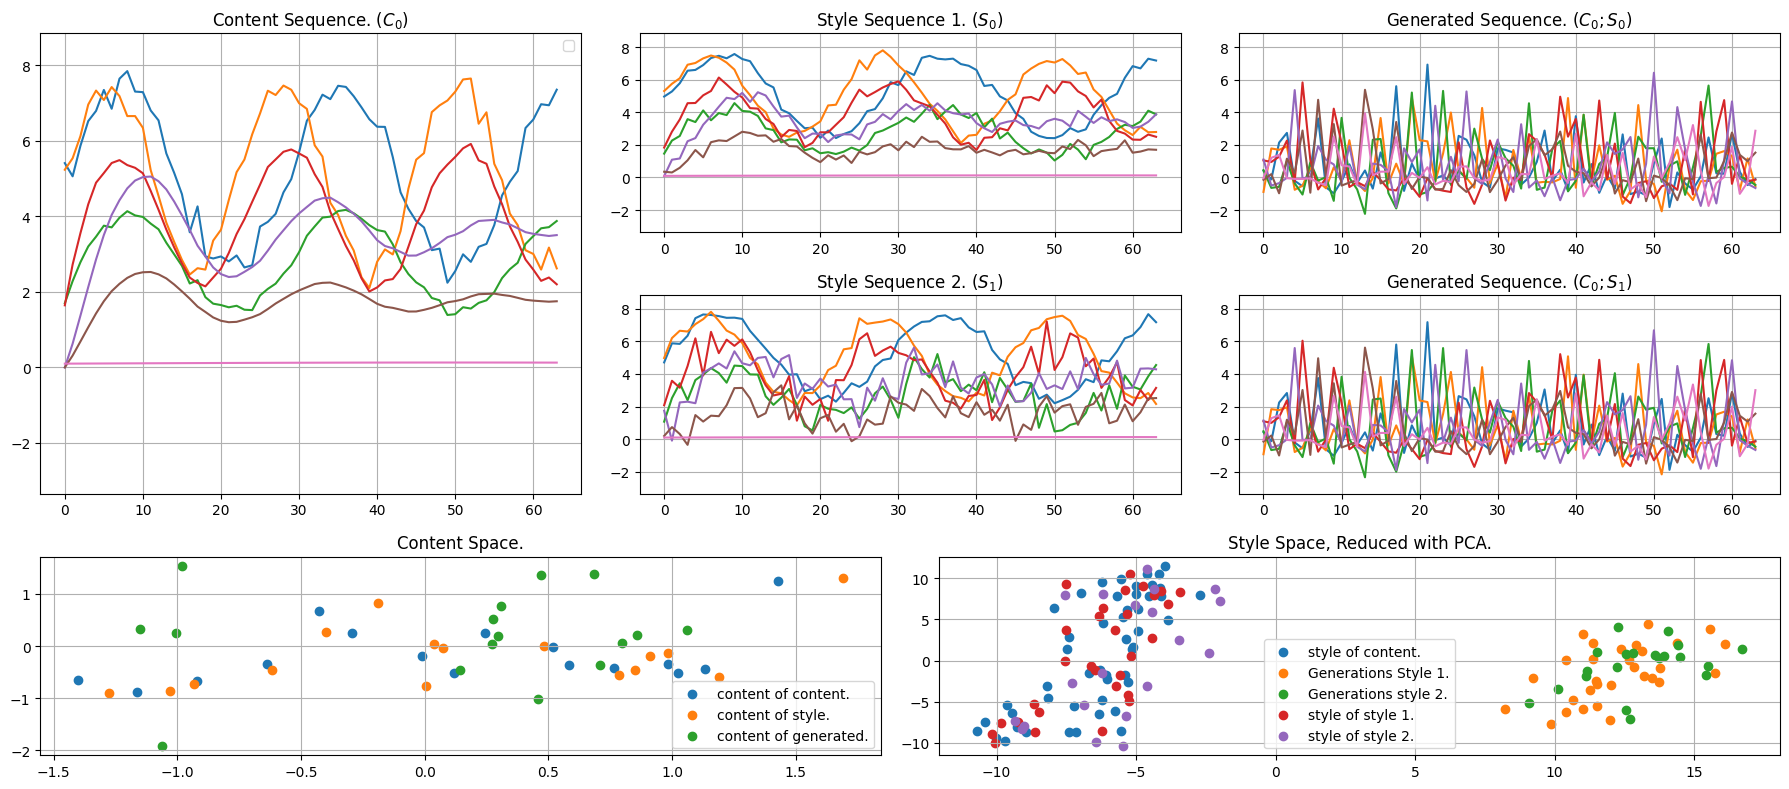

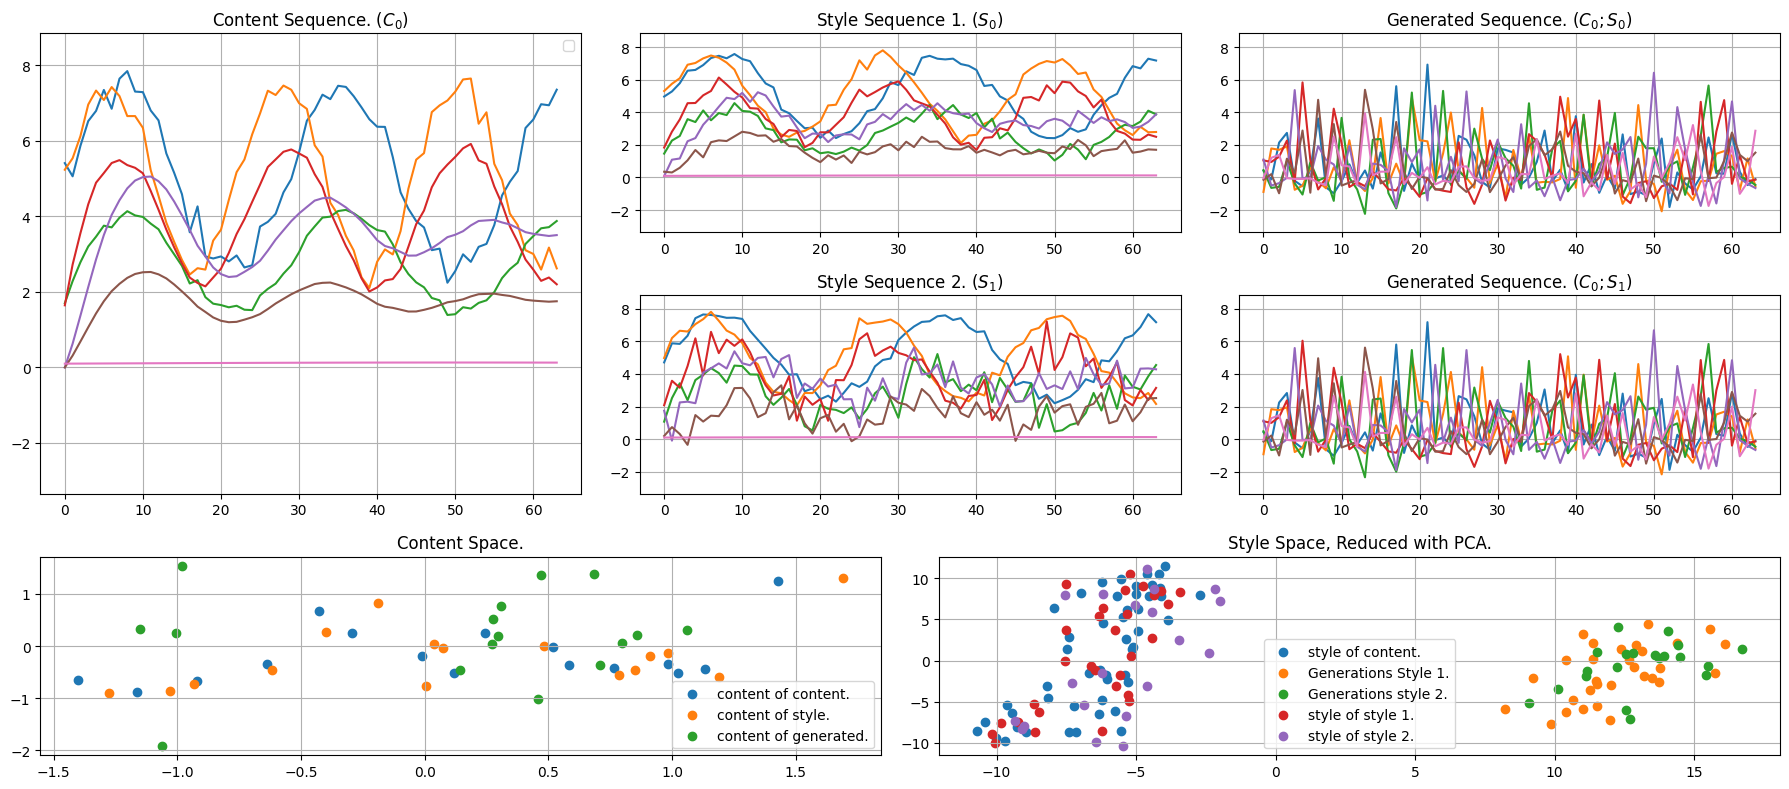

In [25]:
from sklearn.decomposition import PCA

def plot_generated_sequence2(content_sequences, style_sequences, style_labels, show=False):
    
    style_1_sequence = style_sequences[style_labels == 0][0]
    style_2_sequence = style_sequences[style_labels == 1][0]
    content_sequence_for_model = tf.gather(content_sequences, [0, 0])
    style_for_the_model = tf.stack([style_1_sequence, style_2_sequence])

    # Make Generated sequence for visualization.
    content_of_content = content_encoder(content_sequence_for_model, training=False)
    style_of_style= style_encoder(style_for_the_model, training=False)
    generated_sequences = decoder([content_of_content, style_of_style], training=False)


    # Make the computation for the scatter plots 
    content_of_style = content_encoder(style_sequences, training=False)
    style_of_style = style_encoder(style_sequences, training=False)

    content_of_content = content_encoder(content_sequences, training=False)
    style_of_content = style_encoder(content_sequences, training=False)

    generations = decoder([content_of_content, style_of_style], training=False)

    content_of_generated = content_encoder(generations, training=False)
    style_of_generated = style_encoder(generations, training=False)

    # Reduce the Style Vector for visualization purposes.
    pca = PCA(2)
    style_vectors = np.vstack([style_of_content, style_of_style, style_of_generated])

    pca.fit(style_vectors)

    reduced_style_content=pca.transform(style_of_content)
    reduced_style_generations=pca.transform(style_of_generated)
    reduced_style_style = pca.transform(style_of_style)

    reduced_style1 = reduced_style_style[style_labels == 0, :]
    reduced_style2 = reduced_style_style[style_labels == 1, :]

    generated_style1 = reduced_style_generations[style_labels == 0, :]
    generated_style2 = reduced_style_generations[style_labels == 1, :]

    all_values = np.array([content_sequence_for_model, style_for_the_model, generated_sequences])
    _min, _max = np.min(all_values)-1, np.max(all_values)+ 1

    fig= plt.figure(figsize=(18, 8))
    spec= fig.add_gridspec(3, 6)

    ax00 = fig.add_subplot(spec[0:2, :2])
    ax00.set_title('Content Sequence. ($C_0$)')
    ax00.plot(content_sequence_for_model[0])
    ax00.set_ylim(_min, _max)
    ax00.grid(True)
    ax00.legend()

# #######
    ax01 = fig.add_subplot(spec[0, 2:4])
    ax01.set_title('Style Sequence 1. ($S_0$)')
    ax01.plot(style_1_sequence)
    ax01.set_ylim(_min, _max)
    ax01.grid(True)

    ax11 = fig.add_subplot(spec[1, 2:4])
    ax11.set_title("Style Sequence 2. ($S_1$)")
    ax11.plot(style_2_sequence)
    ax11.set_ylim(_min, _max)
    ax11.grid(True)

# #######
    ax02 = fig.add_subplot(spec[0, 4:])
    ax02.set_title('Generated Sequence. ($C_0; S_0$)')
    ax02.plot(generated_sequences[0, :])
    ax02.set_ylim(_min, _max)
    ax02.grid(True) 

    ax12 = fig.add_subplot(spec[1, 4:])
    ax12.set_title('Generated Sequence. ($C_0; S_1$)')
    ax12.plot(generated_sequences[1, :])
    ax12.set_ylim(_min, _max)
    ax12.grid(True) 

# #####
    ax10 = fig.add_subplot(spec[2, :3])
    ax10.set_title('Content Space.')
    ax10.scatter(content_of_content[0, :, 0], content_of_content[0, :, 1],  label='content of content.')
    ax10.scatter(content_of_style[0, :, 0], content_of_style[0, :, 1], label='content of style.')
    ax10.scatter(content_of_generated[0, :, 0], content_of_generated[0, :, 1],  label='content of generated.')
    ax10.grid(True)
    ax10.legend()

    ax11 = fig.add_subplot(spec[2, 3:])
    ax11.set_title('Style Space, Reduced with PCA.')
    ax11.scatter(reduced_style_content[:, 0], reduced_style_content[:, 1], label='style of content.')
    ax11.scatter(generated_style1[:, 0], generated_style1[:, 1], label='Generations Style 1.')
    ax11.scatter(generated_style2[:, 0], generated_style2[:, 1], label='Generations style 2.')

    ax11.scatter(reduced_style1[:, 0], reduced_style1[:, 1], label='style of style 1.')
    ax11.scatter(reduced_style2[:, 0], reduced_style2[:, 1], label='style of style 2.')

    ax11.grid(True)
    ax11.legend()

    plt.tight_layout()

    return fig

plot_generated_sequence2(valid_seed_content, valid_seed_style, valid_seed_style_label)

In [26]:
def fig_to_buff(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    plt.close(fig)
    return buf

## Define losses.

In [27]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
error_classif = tf.keras.losses.SparseCategoricalCrossentropy()


def recontruction_loss(true:tf.Tensor, generated:tf.Tensor):
    diff = generated- true
    result = tf.math.reduce_mean(tf.square(diff))
    return result

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


def fixed_point_content(encoded_content_real, encoded_content_fake):
    diff = encoded_content_fake- encoded_content_real
    return tf.reduce_mean(tf.square(diff))

def style_classsification_loss(y_pred, y_true):
    return error_classif(y_true, y_pred)

## Tensorboard Logs.

In [28]:
# Train Metrics
# Generator Losses
met_generator_train = tf.keras.metrics.Mean(name="Total Generator Loss")
met_generator_reconstr_from_content_train= tf.keras.metrics.Mean(name="Reconstruction from Content")
met_generator_realness_train= tf.keras.metrics.Mean(name="Realness of Generations")

# Style Encoder Loss
met_triplet_train = tf.keras.metrics.Mean(name="Total Triplet Loss")
met_disentanglement_train = tf.keras.metrics.Mean(name="Disentanglement Loss")
met_style_encoder_train = tf.keras.metrics.Mean(name="Style Loss")

# Content encoder Loss
met_content_encoder_train= tf.keras.metrics.Mean(name="Content Encoder Loss")

# Correlation Metric
met_correlation_metric_train = tf.keras.metrics.Mean(name="Correlation Metric")

# Discriminator Loss
met_disc_loss_train= tf.keras.metrics.Mean(name="Discriminator Loss")
met_style_classif_on_real_train = tf.keras.metrics.Mean(name="Style Classification Loss on Real Sequences")
met_style_classif_on_gen_train = tf.keras.metrics.Mean(name="Style Classification Loss on Generated Sequences")

# Style of Reconstruction (ajouté ici mais plus un bout de scotch qu'autre chose...).
met_style_reconstruction = tf.keras.metrics.Mean(name="Style Reconstruction")

# Correlation Metric
met_correlation_metric_train = tf.keras.metrics.Mean(name="Correlation Metric")


# Valid Metrics
# Generator Metric
met_generator_valid = tf.keras.metrics.Mean(name="Total Generator Loss")
met_generator_reconstr_from_content_valid= tf.keras.metrics.Mean(name="Reconstruction from Content")
met_generator_realness_valid= tf.keras.metrics.Mean(name="Realness of Generations")

# Style encoder Loss
met_triplet_valid = tf.keras.metrics.Mean(name="Triplet Loss")
met_disentanglement_valid = tf.keras.metrics.Mean(name="Disentanglement Loss")
met_style_encoder_valid = tf.keras.metrics.Mean(name="Style Loss")

# Content Encoder Loss
met_content_encoder_valid= tf.keras.metrics.Mean(name="Content Encoder Loss")

# Discriminator Loss
met_disc_loss_valid= tf.keras.metrics.Mean(name="Discriminator Loss")
met_style_classif_on_real_valid = tf.keras.metrics.Mean(name="Style Classification Loss on Real Sequences")
met_style_classif_on_gen_valid = tf.keras.metrics.Mean(name="Style Classification Loss on Generated Sequences")

# correlation Metric
met_correlation_metric_valid = tf.keras.metrics.Mean(name="Correlation Metric")

# Style of Reconstruction (ajouté ici mais plus un bout de scotch qu'autre chose...).
met_style_reconstruction_valid = tf.keras.metrics.Mean(name="Style Reconstruction")

In [29]:
TRAIN_SUMMARY_WRITER = tf.summary.create_file_writer(TRAIN_LOGS_DIR_PATH)
VALID_SUMMARY_WRITER = tf.summary.create_file_writer(VALID_LOGS_DIR_PATH)

def log_train_losses(epoch, plot_buf):
    image = tf.image.decode_png(plot_buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)

    with TRAIN_SUMMARY_WRITER.as_default():
        tf.summary.scalar("00 - Correlation Metric", met_correlation_metric_train.result(), step=epoch)

        tf.summary.scalar("10 - Total Generator Loss", met_generator_train.result(), step=epoch)
        tf.summary.scalar("11 - Reconstruction from Content", met_generator_reconstr_from_content_train.result(), step=epoch)
        tf.summary.scalar("12 - Realness Loss", met_generator_realness_train.result(), step=epoch)
        tf.summary.scalar("13 - Style Classification on Generations", met_style_classif_on_gen_train.result(), step=epoch)

        tf.summary.scalar("20 - Style Loss", met_style_encoder_train.result(), step=epoch)
        tf.summary.scalar("21 - Triplet Loss", met_triplet_train.result(), step=epoch)
        tf.summary.scalar("22 - Disentanglement Loss", met_disentanglement_train.result(), step=epoch)

        tf.summary.scalar("30 - Content Loss", met_content_encoder_train.result(), step=epoch)

        tf.summary.scalar("40 - Discriminator Loss", met_disc_loss_train.result(), step=epoch)
        tf.summary.scalar("41 - Style Classification on Real", met_style_classif_on_real_train.result(), step=epoch)

        tf.summary.image("Training Generations", image, step=epoch)


def log_valid_losses(epoch):
    with VALID_SUMMARY_WRITER.as_default():
        tf.summary.scalar("00 - Correlation Metric", met_correlation_metric_valid.result(), step=epoch)

        tf.summary.scalar("10 - Total Generator Loss", met_generator_valid.result(), step=epoch)
        tf.summary.scalar("11 - Reconstruction from Content", met_generator_reconstr_from_content_valid.result(), step=epoch)
        tf.summary.scalar("12 - Realness Loss", met_generator_realness_valid.result(), step=epoch)
        tf.summary.scalar("13 - Style Classification on Generations", met_style_classif_on_gen_valid.result(), step=epoch)

        tf.summary.scalar("20 - Style Loss", met_style_encoder_valid.result(), step=epoch)
        tf.summary.scalar("21 - Triplet Loss", met_triplet_valid.result(), step=epoch)
        tf.summary.scalar("22 - Disentanglement Loss", met_disentanglement_valid.result(), step=epoch)

        tf.summary.scalar("30 - Content Loss", met_content_encoder_valid.result(), step=epoch)

        tf.summary.scalar("40 - Discriminator Loss", met_disc_loss_valid.result(), step=epoch)
        tf.summary.scalar("41 - Style Classification on Real", met_style_classif_on_real_valid.result(), step=epoch)
        


def reset_metric_states():
    met_generator_train.reset_states()
    met_generator_reconstr_from_content_train.reset_states()
    met_generator_realness_train.reset_states()
    met_triplet_train.reset_states()
    met_disentanglement_train.reset_states()
    met_style_encoder_train.reset_states()
    met_content_encoder_train.reset_states()
    met_correlation_metric_train.reset_states()
    met_disc_loss_train.reset_states()
    met_style_reconstruction.reset_states()
    met_correlation_metric_train.reset_states()
    met_style_classif_on_real_train.reset_states()
    met_style_classif_on_gen_train.reset_states()


def reset_valid_states():
    met_generator_valid.reset_states()
    met_generator_reconstr_from_content_valid.reset_states()
    met_generator_realness_valid.reset_states()
    met_triplet_valid.reset_states()
    met_disentanglement_valid.reset_states()
    met_style_encoder_valid.reset_states()
    met_content_encoder_valid.reset_states()
    met_correlation_metric_valid.reset_states()
    met_disc_loss_valid.reset_states()
    met_style_reconstruction.reset_states()
    met_correlation_metric_valid.reset_states()
    met_style_classif_on_real_valid.reset_states()
    met_style_classif_on_gen_valid.reset_states()


## Instantiate model for training.

In [30]:
content_encoder = make_content_encoder(SEQUENCE_LENGTH, N_SIGNAL, FEAT_WIENER)
style_encoder = make_style_encoder(SEQUENCE_LENGTH, N_SIGNAL, STYLE_VECTOR_SIZE)
decoder = make_decoder(N_SAMPLE_WIENER, FEAT_WIENER, STYLE_VECTOR_SIZE ,N_SIGNAL)


opt_content_encoder = tf.keras.optimizers.Adam(learning_rate=0.0002)
opt_style_encoder = tf.keras.optimizers.Adam(learning_rate=0.0002)
opt_decoder = tf.keras.optimizers.Adam(learning_rate=0.0002)
opt_discr = tf.keras.optimizers.Adam(learning_rate=0.0002)

# opt_content_encoder = tf.keras.optimizers.RMSprop(learning_rate=1e-4)
# opt_style_encoder = tf.keras.optimizers.RMSprop(learning_rate=1e-4)
# opt_decoder = tf.keras.optimizers.RMSprop(learning_rate=1e-3)
# opt_discr = tf.keras.optimizers.RMSprop(learning_rate=1e-5)

## Train the model

In [31]:
from itertools import product
indexes = np.array(list(product(range(BS), range(BS))))
other_index = np.arange(BS)* BS

In [32]:
anchor_indexes = np.array([ i* BS+i for i in range(BS) for _ in range(BS) ])
pos_indexes = np.array([ BS*j + i for i in range(BS) for j in range(BS)])
neg_indexes = np.array([ (j*BS + (i+1)%BS) for i in range(BS) for j in range(BS)])

In [33]:
def get_style_voctor_for_dis_loss(style_vector:tf.Tensor, batch_size:int):
    anchor_indexes = np.array([ i* batch_size+i for i in range(batch_size) for _ in range(batch_size-1) ])
    return tf.gather(style_vector, anchor_indexes)

def get_anchor_positive_negative_from_batch(style_from_style_ts:tf.Tensor, style_of_generations:tf.Tensor, batch_size:int):
    anchor_indexes = np.array([ i* batch_size+i for i in range(batch_size) for _ in range(batch_size) ])
    pos_indexes = np.array([ batch_size*j + i for i in range(batch_size) for j in range(batch_size)])
    neg_indexes = np.array([ (j*batch_size + (i+1)%batch_size) for i in range(batch_size) for j in range(batch_size)])

    # Anchor are for example:
    # [(c0, s0), (c0, s0), 
    # (c1, s1), (c1, s1), ...]
    anchors = tf.gather(style_from_style_ts, anchor_indexes)
    # Different content, Same Style:
    # [(c1, s0), (c2, s0),(c2, s0),
    #  (c1, s1), (c2, s1), (c3, s1)...]
    # E_s(G(x, y1))
    pos_vector= tf.gather(style_of_generations, pos_indexes)
    # Same content but different style
    # [(c1, s1), (c2, s1),(c2, s1),
    #  (c1, s2), (c2, s2), (c3, s2)...]
    # # E_s(G(x, y2)) 
    neg_vector = tf.gather(style_of_generations, neg_indexes)

    return anchors, pos_vector, neg_vector

def get_dissantanglement_loss_component(style_of_generations, style_of_style, batch_size:int):
    anchor_indexes = np.array([ i* batch_size+i for i in range(batch_size) for _ in range(batch_size-1) ])
    pos_indexes = np.array([ batch_size*j + i for i in range(batch_size) for j in range(batch_size) if i !=j ])

    es_y = tf.gather(style_of_style, anchor_indexes)
    es_x1_y = tf.gather(style_of_generations, anchor_indexes)
    es_x2_y = tf.gather(style_of_generations, pos_indexes)

    return es_y, es_x1_y, es_x2_y


def l2(x:tf.Tensor, y:tf.Tensor):
    diff = tf.square(y- x)
    _distance = tf.reduce_sum(diff, axis=-1)
    return _distance


def fixed_point_content(encoded_content_real, encoded_content_fake):
    diff = l2(encoded_content_real, encoded_content_fake)
    return tf.reduce_mean(diff)

def fixed_point_triplet_style_loss(anchor_encoded_style, positive_encoded_style, negative_encoded_style):
    # shape: [BS, Style_length]
    negative_distance = l2(negative_encoded_style, anchor_encoded_style)
    positive_distance = l2(positive_encoded_style, anchor_encoded_style)

    triplet = TRIPLET_R+ positive_distance- negative_distance
    zeros = tf.zeros_like(triplet)
    triplet = tf.math.maximum(triplet, zeros)

    loss = tf.reduce_mean(triplet)
    return loss

def fixed_point_disentanglement(
        es_x1_y:tf.Tensor, 
        es_x2_y:tf.Tensor, 
        es_y:tf.Tensor
        ):

    diff1 = l2(es_x1_y, es_x2_y)
    diff2 = l2(es_x1_y, es_y)

    loss = diff1- diff2
    zeros = tf.zeros_like(loss)
    loss = tf.math.maximum(loss, zeros)
    loss = tf.reduce_mean(loss)
    return loss


def style_constrain_loss(style_of_style_batch, style_of_generation):
    diff = l2(style_of_style_batch, style_of_generation)
    diff = tf.reduce_mean(diff)
    return diff

In [34]:
def _pairwise_distance(a_embeddings, b_embeddings):
    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    dot_product = tf.matmul(a_embeddings, tf.transpose(b_embeddings))

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = tf.linalg.diag_part(dot_product)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = tf.expand_dims(square_norm, 0) - 2.0 * dot_product + tf.expand_dims(square_norm, 1)

    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = tf.maximum(distances, 0.0)

    return distances

def get_positives(labels):
    # will assign 1 where this is a positive 
    positive_mask = np.array([ tf.cast(labels == l, tf.float32) for l in labels])
    positive_mask = positive_mask - np.identity(positive_mask.shape[0])
    return positive_mask

def get_negative(labels):
    neg_labels= np.array([ tf.cast(labels != l, tf.float32) for l in labels])
    return neg_labels


def get_triplet_loss(anchor_embedding, positive_embedding, negative_embedding):
    positive_distance= _pairwise_distance(anchor_embedding, positive_embedding)
    negative_distance= _pairwise_distance(anchor_embedding, negative_embedding)

    positive_index= tf.argmax(positive_distance, axis=1)

    pos_embedding = tf.gather(positive_embedding, positive_index)
 
    neg_indexes = tf.argmin(negative_distance, axis=1)
    
    neg_embeddings= tf.gather(negative_embedding, neg_indexes)

    positive_distances= l2(anchor_embedding, pos_embedding)
    negative_distances= l2(anchor_embedding, neg_embeddings)

    loss = tf.reduce_mean(tf.maximum(TRIPLET_R+ positive_distances - negative_distances, 0))

    return loss

In [35]:
def train_step(content_sequences, style_sequences, style_labels, update_discr):


        # Discriminator Step
    with tf.GradientTape() as discr_tape:
        # Sequence generations.
        encoded_content = content_encoder(content_sequences, training=update_discr)
        encoded_style = style_encoder(style_sequences, training=update_discr)
        generated_sequences= decoder([encoded_content, encoded_style], training=update_discr)

        # We classify style sequences because 
        # they are only real sequences with style labels :) 
        crit_real, style_classif_real = global_discriminator(style_sequences, training=update_discr)
        crit_fake, style_classif_fake = global_discriminator(generated_sequences, training=update_discr)

        # Compute the loss for the Discriminator
        crit_loss = discriminator_loss(crit_real, crit_fake) # Real or fake Sequences...
        l_style_real = style_classsification_loss(style_classif_real, style_labels)

    # Generate Style Sequence for the `L_{FPT_content}` loss.
    shifted_style_sequences= tf.roll(style_sequences, 1, 1)
    shifted_content_sequences=tf.roll(content_sequences, 1, 1)

    # Here, things get a little bit more complicated :)
    with tf.GradientTape() as content_tape, tf.GradientTape() as style_tape, tf.GradientTape() as decoder_tape:
        encoded_content = content_encoder(content_sequences, training=True)
        encoded_style = style_encoder(style_sequences, training=True)
        generated_sequences= decoder([encoded_content, encoded_style], training=True)

        shifted_enc_content= content_encoder(shifted_content_sequences, training=True)
        shifted_enc_style = style_encoder(shifted_style_sequences, training=True) 

        generated_for_lfp_style = decoder([encoded_content, shifted_enc_style], training=False)
        generated_for_dis = decoder([shifted_enc_content, encoded_style], training=False)
        
        # extract the content and the style vector for fix point losses
        content_from_generations = content_encoder(generated_sequences, training=True)
        style_from_generations = style_encoder(generated_sequences, training=True)
        style_from_shifted_style = style_encoder(generated_for_lfp_style, training=True)
        style_from_shifted_content= style_encoder(generated_for_dis, training=True)

        # Discriminator pass for the adversarial loss for the generator.
        crit_fake, style_classif_fake = global_discriminator(generated_sequences, training=False)

        reconstr_loss = recontruction_loss(content_sequences, generated_sequences)
        realness = generator_loss(crit_fake)
        # The Style label should be preserved through generations...
        style_label_preservation = style_classsification_loss(style_classif_fake, style_labels)

        content_preservation = fixed_point_content(encoded_content, content_from_generations)

        triplet_style =  get_triplet_loss(encoded_style, style_from_generations, style_from_shifted_style)

        content_style_disentenglement = fixed_point_disentanglement(encoded_style, style_from_generations, style_from_shifted_content)

        content_encoder_loss = L_CONTENT* content_preservation
        style_encoder_loss = L_TRIPLET* triplet_style + L_DIS* content_style_disentenglement
        g_loss = L_RECONSTR* reconstr_loss+ L_ADV* realness + L_ADV* style_label_preservation

    # Make the Networks Learn!
    if update_discr == True:
        discr_grads = discr_tape.gradient([crit_loss, l_style_real], global_discriminator.trainable_variables)
    content_grad=content_tape.gradient(content_encoder_loss, content_encoder.trainable_variables)
    style_grad = style_tape.gradient(style_encoder_loss, style_encoder.trainable_variables)
    decoder_grad = decoder_tape.gradient(g_loss, decoder.trainable_variables)
        
    if update_discr == True:
        opt_discr.apply_gradients(zip(discr_grads, global_discriminator.trainable_variables))
    opt_content_encoder.apply_gradients(zip(content_grad, content_encoder.trainable_variables))
    opt_style_encoder.apply_gradients(zip(style_grad, style_encoder.trainable_variables))
    opt_decoder.apply_gradients(zip(decoder_grad, decoder.trainable_variables))

    met_generator_train(g_loss)
    met_style_classif_on_gen_train(style_label_preservation)
    met_generator_reconstr_from_content_train(reconstr_loss)
    met_generator_realness_train(realness)

    met_style_encoder_train(style_encoder_loss)
    met_triplet_train(triplet_style)
    met_disentanglement_train(content_style_disentenglement)

    met_content_encoder_train(content_preservation)
    met_disc_loss_train(crit_loss)
    met_style_classif_on_real_train(l_style_real)
        

def valid_step(content_sequences, style_sequences, style_labels):
    # Sequence generations.
    encoded_content = content_encoder(content_sequences, training=False)
    encoded_style = style_encoder(style_sequences, training=False)
    generated_sequences= decoder([encoded_content, encoded_style], training=False)

    # We classify style sequences because 
    # they are only real sequences with style labels :) 
    crit_real, style_classif_real = global_discriminator(style_sequences, training=True)
    crit_fake, style_classif_fake = global_discriminator(generated_sequences, training=True)

    # Compute the loss for the Discriminator
    crit_loss = discriminator_loss(crit_real, crit_fake) # Real or fake Sequences...
    l_style_real = style_classsification_loss(style_classif_real, style_labels)

    # Generate Style Sequence for the `L_{FPT_content}` loss.
    shifted_style_sequences= tf.roll(style_sequences, 1, 1)
    shifted_content_sequences=tf.roll(content_sequences, 1, 1)

    encoded_content = content_encoder(content_sequences, training=False)
    encoded_style = style_encoder(style_sequences, training=False)
    generated_sequences= decoder([encoded_content, encoded_style], training=False)

    shifted_enc_content= content_encoder(shifted_content_sequences, training=False)
    shifted_enc_style = style_encoder(shifted_style_sequences, training=False) 

    generated_for_lfp_style = decoder([encoded_content, shifted_enc_style], training=False)
    generated_for_dis = decoder([shifted_enc_content, encoded_style], training=False)
    
    # extract the content and the style vector for fix point losses
    content_from_generations = content_encoder(generated_sequences, training=False)
    style_from_generations = style_encoder(generated_sequences, training=False)
    style_from_shifted_style = style_encoder(generated_for_lfp_style, training=False)
    style_from_shifted_content= style_encoder(generated_for_dis, training=False)

    # Discriminator pass for the adversarial loss for the generator.
    crit_fake, style_classif_fake = global_discriminator(generated_sequences, training=False)

    reconstr_loss = recontruction_loss(content_sequences, generated_sequences)
    realness = generator_loss(crit_fake)
    # The Style label should be preserved through generations...
    style_label_preservation = style_classsification_loss(style_classif_fake, style_labels)

    content_preservation = fixed_point_content(encoded_content, content_from_generations)

    triplet_style =  get_triplet_loss(encoded_style, style_from_generations, style_from_shifted_style)

    content_style_disentenglement = fixed_point_disentanglement(encoded_style, style_from_generations, style_from_shifted_content)

    content_encoder_loss = content_preservation
    style_encoder_loss = triplet_style + content_style_disentenglement
    g_loss = reconstr_loss+ realness + style_label_preservation

    met_generator_valid(g_loss)
    met_style_classif_on_gen_valid(style_label_preservation)
    met_generator_reconstr_from_content_valid(reconstr_loss)
    met_generator_realness_valid(realness)

    met_style_encoder_valid(style_encoder_loss)
    met_triplet_valid(triplet_style)
    met_disentanglement_valid(content_style_disentenglement)

    met_content_encoder_valid(content_preservation)
    met_disc_loss_valid(crit_loss)
    met_style_classif_on_real_valid(l_style_real)


In [36]:
def compute_metric(generated_style:tf.Tensor, true_style:tf.Tensor):
    true_signature = signature_on_batch(true_style, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)
    generated_signature= signature_on_batch(generated_style, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)

    return signature_metric(true_signature, generated_signature)

In [37]:
def train():
    total_batch = "?"
    for e in range(EPOCHS):
        reset_metric_states()
        reset_valid_states()
        
        print("[+] Train Step...")
        for i, (content_batch, (style_sequences, style_labels)) in enumerate(zip(content_dset_train, style_dset_train)):
            update_discr = i%DISCR_STEP == 0

            train_step(content_batch, style_sequences, style_labels, update_discr)


            print(f"\r e:{e}/{EPOCHS}; {i}/{total_batch}. \
G_loss {met_generator_train.result():0.2f} \
Triplet Loss {met_triplet_train.result():0.2f}; \
Disentanglement Loss: {met_disc_loss_train.result():0.2f}; \
Content Loss {met_content_encoder_train.result():0.2f} \
D Loss {met_disc_loss_train.result():0.2f}; \
Classif [Real; Fake]: [{met_style_classif_on_real_train.result():0.2f}; {met_style_classif_on_gen_train.result():0.2f}] {update_discr}        ", end="")
            # return

        print()
        print("[+] Validation Step...")
        for vb, (content_batch, (style_sequences, style_labels)) in enumerate(zip(content_dset_valid, style_dset_valid)):
            valid_step(content_batch, style_sequences, style_labels)
            print(f"\r e:{e}/{EPOCHS}; {vb}. \
G_loss {met_generator_valid.result():0.2f} \
Triplet Loss {met_triplet_valid.result():0.2f}; \
Disentanglement Loss: {met_disc_loss_train.result():0.2f}; \
Content Loss {met_content_encoder_train.result():0.2f} \
D Loss {met_disc_loss_train.result():0.2f}\
Classif [Real; Fake]: [{met_style_classif_on_real_valid.result():0.2f}; {met_style_classif_on_gen_valid.result():0.2f}]         ", end="")
    
        # Make Generations Train Set
        generation_style1_train = generate(seed_content_train, seed_style1_train)
        generation_style1_valid = generate(seed_content_valid, seed_style1_valid)

        generation_style2_train = generate(seed_content_train, seed_style2_train)
        generation_style2_valid = generate(seed_content_valid, seed_style2_valid)
        
        metric_s1_train = compute_metric(generation_style1_train, seed_style1_train)
        metric_s1_valid = compute_metric(generation_style1_valid, seed_style1_valid)

        metric_s2_train = compute_metric(generation_style2_train, seed_style2_train)
        metric_s2_valid = compute_metric(generation_style2_valid, seed_style2_valid)


        signature_train= (metric_s1_train+ metric_s2_train)/2
        signature_valid= (metric_s1_valid+ metric_s2_valid)/2

        met_correlation_metric_train(signature_train)
        met_correlation_metric_valid(signature_valid)

        vis_fig = plot_generated_sequence2(valid_seed_content, valid_seed_style, valid_seed_style_label)
        plot_buff = fig_to_buff(vis_fig)
        
        print(f"\n[+] Signature Difference: \n - Train: {signature_train:0.2f}\n - Valid {signature_valid:0.2f}")

        log_train_losses(e, plot_buff)
        log_valid_losses(e)
        print()

        if e == 0:
            total_batch = i 

train()

[+] Train Step...


2024-06-06 12:08:34.547544: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x5625f6d43350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-06 12:08:34.547570: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-06-06 12:08:34.552138: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-06 12:08:34.676840: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 e:0/50; 499/?. G_loss 0.53 Triplet Loss 5.88; Disentanglement Loss: 1.37; Content Loss 0.36 D Loss 1.37; Classif [Real; Fake]: [0.74; 0.73] False         
[+] Validation Step...


2024-06-06 12:11:27.784574: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-06 12:11:27.785190: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 e:0/50; 9. G_loss 3.82 Triplet Loss 22.31; Disentanglement Loss: 1.37; Content Loss 0.36 D Loss 1.37Classif [Real; Fake]: [0.72; 0.72]         

2024-06-06 12:11:29.413529: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-06 12:11:29.413579: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argum


[+] Signature Difference: 
 - Train: 34.51
 - Valid 31.14

[+] Train Step...
 e:1/50; 499/499. G_loss 0.18 Triplet Loss 1.07; Disentanglement Loss: 1.38; Content Loss 0.01 D Loss 1.38; Classif [Real; Fake]: [0.76; 0.74] False        
[+] Validation Step...


2024-06-06 12:14:17.314193: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-06 12:14:17.314777: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 e:1/50; 9. G_loss 2.72 Triplet Loss 10.24; Disentanglement Loss: 1.38; Content Loss 0.01 D Loss 1.38Classif [Real; Fake]: [0.70; 0.70]         

2024-06-06 12:14:18.923720: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-06 12:14:18.923777: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argum


[+] Signature Difference: 
 - Train: 16.07
 - Valid 5.33

[+] Train Step...
 e:2/50; 499/499. G_loss 0.16 Triplet Loss 0.83; Disentanglement Loss: 1.36; Content Loss 0.00 D Loss 1.36; Classif [Real; Fake]: [0.70; 0.69] False        
[+] Validation Step...


2024-06-06 12:17:10.328745: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-06 12:17:10.329268: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 e:2/50; 9. G_loss 2.92 Triplet Loss 5.66; Disentanglement Loss: 1.36; Content Loss 0.00 D Loss 1.36Classif [Real; Fake]: [0.70; 0.70]         

2024-06-06 12:17:11.971571: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-06 12:17:11.971624: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argum


[+] Signature Difference: 
 - Train: 6.14
 - Valid 0.81

[+] Train Step...
 e:3/50; 499/499. G_loss 0.15 Triplet Loss 0.74; Disentanglement Loss: 1.28; Content Loss 0.00 D Loss 1.28; Classif [Real; Fake]: [0.70; 0.70] False        
[+] Validation Step...


2024-06-06 12:20:01.637116: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-06 12:20:01.637728: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 e:3/50; 9. G_loss 2.68 Triplet Loss 10.45; Disentanglement Loss: 1.28; Content Loss 0.00 D Loss 1.28Classif [Real; Fake]: [0.70; 0.69]         

2024-06-06 12:20:03.266875: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-06 12:20:03.266925: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argum


[+] Signature Difference: 
 - Train: 66.71
 - Valid 76.98

[+] Train Step...
 e:4/50; 499/499. G_loss 0.15 Triplet Loss 0.60; Disentanglement Loss: 0.95; Content Loss 0.00 D Loss 0.95; Classif [Real; Fake]: [0.72; 0.70] False        
[+] Validation Step...


2024-06-06 12:22:51.726540: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-06 12:22:51.726984: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 e:4/50; 9. G_loss 2.65 Triplet Loss 6.74; Disentanglement Loss: 0.95; Content Loss 0.00 D Loss 0.95Classif [Real; Fake]: [0.75; 0.70]         

2024-06-06 12:22:53.338087: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-06 12:22:53.338138: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argum


[+] Signature Difference: 
 - Train: 34.63
 - Valid 21.03

[+] Train Step...
 e:5/50; 499/499. G_loss 0.14 Triplet Loss 0.49; Disentanglement Loss: 0.77; Content Loss 0.00 D Loss 0.77; Classif [Real; Fake]: [0.71; 0.70] False        
[+] Validation Step...


2024-06-06 12:25:41.673987: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-06 12:25:41.674361: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 e:5/50; 9. G_loss 5.00 Triplet Loss 6.52; Disentanglement Loss: 0.77; Content Loss 0.00 D Loss 0.77Classif [Real; Fake]: [0.71; 0.69]         

2024-06-06 12:25:43.310583: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-06 12:25:43.310641: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argum


[+] Signature Difference: 
 - Train: 53.57
 - Valid 27.17

[+] Train Step...
 e:6/50; 499/499. G_loss 0.14 Triplet Loss 0.49; Disentanglement Loss: 0.84; Content Loss 0.00 D Loss 0.84; Classif [Real; Fake]: [0.71; 0.69] False        
[+] Validation Step...


2024-06-06 12:28:31.418562: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-06 12:28:31.419238: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 e:6/50; 9. G_loss 3.49 Triplet Loss 4.62; Disentanglement Loss: 0.84; Content Loss 0.00 D Loss 0.84Classif [Real; Fake]: [0.71; 0.70]         

2024-06-06 12:28:33.041752: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-06 12:28:33.041805: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argum


[+] Signature Difference: 
 - Train: 31.50
 - Valid 25.02

[+] Train Step...
 e:7/50; 499/499. G_loss 0.13 Triplet Loss 0.37; Disentanglement Loss: 0.60; Content Loss 0.01 D Loss 0.60; Classif [Real; Fake]: [0.72; 0.69] False        
[+] Validation Step...


2024-06-06 12:31:23.779572: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-06 12:31:23.779966: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 e:7/50; 9. G_loss 4.38 Triplet Loss 8.65; Disentanglement Loss: 0.60; Content Loss 0.01 D Loss 0.60Classif [Real; Fake]: [0.73; 0.71]          

2024-06-06 12:31:25.390870: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-06 12:31:25.390921: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argum


[+] Signature Difference: 
 - Train: 77.70
 - Valid 54.88

[+] Train Step...
 e:8/50; 499/499. G_loss 0.14 Triplet Loss 0.34; Disentanglement Loss: 0.80; Content Loss 0.00 D Loss 0.80; Classif [Real; Fake]: [0.72; 0.69] False        
[+] Validation Step...


2024-06-06 12:34:15.538798: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-06 12:34:15.539285: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 e:8/50; 9. G_loss 2.62 Triplet Loss 7.21; Disentanglement Loss: 0.80; Content Loss 0.00 D Loss 0.80Classif [Real; Fake]: [0.75; 0.70]          

2024-06-06 12:34:17.162445: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-06 12:34:17.162494: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argum


[+] Signature Difference: 
 - Train: 20.04
 - Valid 32.84

[+] Train Step...
 e:9/50; 499/499. G_loss 0.16 Triplet Loss 0.58; Disentanglement Loss: 0.56; Content Loss 0.03 D Loss 0.56; Classif [Real; Fake]: [0.74; 0.70] False        
[+] Validation Step...


2024-06-06 12:37:05.779202: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-06 12:37:05.779658: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 e:9/50; 9. G_loss 4.32 Triplet Loss 5.86; Disentanglement Loss: 0.56; Content Loss 0.03 D Loss 0.56Classif [Real; Fake]: [0.73; 0.69]          

2024-06-06 12:37:07.366198: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-06 12:37:07.366250: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argum


[+] Signature Difference: 
 - Train: 14.77
 - Valid 14.44

[+] Train Step...
 e:10/50; 499/499. G_loss 0.15 Triplet Loss 0.38; Disentanglement Loss: 0.35; Content Loss 0.00 D Loss 0.35; Classif [Real; Fake]: [0.71; 0.69] False        
[+] Validation Step...


2024-06-06 12:39:57.543018: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-06 12:39:57.543413: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 e:10/50; 9. G_loss 5.48 Triplet Loss 2.98; Disentanglement Loss: 0.35; Content Loss 0.00 D Loss 0.35Classif [Real; Fake]: [0.74; 0.69]         

2024-06-06 12:39:59.175049: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-06 12:39:59.175104: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argum


[+] Signature Difference: 
 - Train: 106.28
 - Valid 71.92

[+] Train Step...
 e:11/50; 499/499. G_loss 0.15 Triplet Loss 0.31; Disentanglement Loss: 0.39; Content Loss 0.00 D Loss 0.39; Classif [Real; Fake]: [0.74; 0.71] False        
[+] Validation Step...


2024-06-06 12:42:48.045104: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-06 12:42:48.045640: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 e:11/50; 9. G_loss 4.84 Triplet Loss 3.00; Disentanglement Loss: 0.39; Content Loss 0.00 D Loss 0.39Classif [Real; Fake]: [0.75; 0.70]         

2024-06-06 12:42:49.681692: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-06 12:42:49.681748: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argum


[+] Signature Difference: 
 - Train: 13.33
 - Valid 4.99

[+] Train Step...
 e:12/50; 499/499. G_loss 0.16 Triplet Loss 0.30; Disentanglement Loss: 0.16; Content Loss 0.00 D Loss 0.16; Classif [Real; Fake]: [0.77; 0.70] False        
[+] Validation Step...


2024-06-06 12:45:38.000254: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-06 12:45:38.000779: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 e:12/50; 9. G_loss 6.18 Triplet Loss 2.69; Disentanglement Loss: 0.16; Content Loss 0.00 D Loss 0.16Classif [Real; Fake]: [0.75; 0.69]         

2024-06-06 12:45:39.639750: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-06 12:45:39.639821: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argum


[+] Signature Difference: 
 - Train: 49.23
 - Valid 23.31

[+] Train Step...
 e:13/50; 499/499. G_loss 0.16 Triplet Loss 0.32; Disentanglement Loss: 0.23; Content Loss 0.00 D Loss 0.23; Classif [Real; Fake]: [0.73; 0.70] False        
[+] Validation Step...


2024-06-06 12:48:28.800260: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-06 12:48:28.800652: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 e:13/50; 9. G_loss 7.59 Triplet Loss 3.49; Disentanglement Loss: 0.23; Content Loss 0.00 D Loss 0.23Classif [Real; Fake]: [0.75; 0.72]         

2024-06-06 12:48:30.391846: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-06 12:48:30.391899: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argum


[+] Signature Difference: 
 - Train: 20.79
 - Valid 10.52

[+] Train Step...
 e:14/50; 499/499. G_loss 0.15 Triplet Loss 0.29; Disentanglement Loss: 0.23; Content Loss 0.00 D Loss 0.23; Classif [Real; Fake]: [0.73; 0.70] False        
[+] Validation Step...


2024-06-06 12:51:18.836253: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-06 12:51:18.836661: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 e:14/50; 9. G_loss 7.23 Triplet Loss 4.04; Disentanglement Loss: 0.23; Content Loss 0.00 D Loss 0.23Classif [Real; Fake]: [0.74; 0.72]         

2024-06-06 12:51:20.471144: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-06 12:51:20.471200: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argum


[+] Signature Difference: 
 - Train: 80.07
 - Valid 47.12

[+] Train Step...
 e:15/50; 186/499. G_loss 0.15 Triplet Loss 0.23; Disentanglement Loss: 0.24; Content Loss 0.00 D Loss 0.24; Classif [Real; Fake]: [0.75; 0.72] False        

2024-06-06 12:52:26.965976: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-06 12:52:26.966517: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


KeyboardInterrupt: 

## Test Pipeline

### Correlation Metric

In [ ]:
def correlation_on_dataset():
    _df_d1= pd.read_hdf(D1_PATH).astype(np.float32)
    _df_d2= pd.read_hdf(D2_PATH).astype(np.float32)

    _df_d1 = _df_d1.drop(columns=['labels'])
    _df_d2 = _df_d2.drop(columns=['labels'])

    _, _dset_d1_valid = make_train_valid_dset(
        _df_d1, 
        SEQUENCE_LENGTH, 
        GRANUARITY, 
        int(OVERLAP* SEQUENCE_LENGTH),
        BS,
        valid_set_size=500
    )

    _, _dset_d2_valid = make_train_valid_dset(
        _df_d2, 
        SEQUENCE_LENGTH, 
        GRANUARITY, 
        int(OVERLAP* SEQUENCE_LENGTH),
        BS,
        valid_set_size=500
    )

    d1_sequence, d2_sequence = next(iter(_dset_d1_valid)), next(iter(_dset_d2_valid))

    generated_batch = generate(d1_sequence, d2_sequence)

    real_validation_signature = signature_on_batch(d2_sequence, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)
    generated_signature = signature_on_batch(generated_batch, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)

    sig_difference = signature_metric(real_validation_signature, generated_signature)

    return sig_difference

### TSTR Method

In [ ]:
from models.NaiveClassifier import make_naive_discriminator

def make_classification_dataset(df:pd.DataFrame, overlap:float=.5):

    dset_train, dset_valid = make_train_valid_dset(
        df, 
        SEQUENCE_LENGTH, 
        GRANUARITY, 
        int(overlap* SEQUENCE_LENGTH),
        BS,
        shuffle=False
    )

    # Extract labels from dataset.
    dset_train = dset_train.map(lambda s: (s[:, :, :-1], s[:, int(SEQUENCE_LENGTH//2), -1]))
    dset_valid = dset_valid.map(lambda s: (s[:, :, :-1], s[:, int(SEQUENCE_LENGTH//2), -1]))

    return dset_train, dset_valid

def stylize_dataset(content_dataset:tf.data.Dataset, style_dataset:tf.data.Dataset):
    mixted_dataset = tf.data.Dataset.zip((content_dataset, style_dataset))
    stylized_dataset = mixted_dataset.map(lambda _cont, _sty: (generate(_cont[0], _sty[0]), _cont[1]))
    return stylized_dataset


def train_naive_classifier(train_classif_dataset:tf.data.Dataset, valid_classif_dataset:tf.data.Dataset)->tf.keras.models.Model:
    naive_model = make_naive_discriminator((SEQUENCE_LENGTH, N_FEAT), 5)
    _epochs = 1

    naive_model.fit(train_classif_dataset, validation_data=valid_classif_dataset, epochs=_epochs)

    return naive_model

def tstr_test():
    _df_d1= pd.read_hdf(D1_PATH).astype(np.float32)
    _df_d2= pd.read_hdf(D2_PATH).astype(np.float32)

    _dset_d1_train, _dset_d1_valid = make_classification_dataset(_df_d1)
    _dset_d2_train, _dset_d2_valid = make_classification_dataset(_df_d2)

    # Generate the 'stylized' dataset 
    _dset_12_train = stylize_dataset(_dset_d1_train, _dset_d2_train)
    _dset_12_valid = stylize_dataset(_dset_d1_valid, _dset_d2_valid)

    # Train a classifier on the stylized dataset.
    naive_12_model = train_naive_classifier(_dset_12_train, _dset_12_valid)
    eval_on_generated = naive_12_model.evaluate(_dset_12_valid)[1]

    # Train on the real Dataset.
    naive_on_real = train_naive_classifier(_dset_d2_train, _dset_d2_valid)
    eval_on_real = naive_on_real.evaluate(_dset_d2_valid)[1]

    return eval_on_generated, eval_on_real

## Log Results

In [ ]:
def log_results(folder_to_save:str, acc_real, acc_generated, sig_diff):
    # Create the folder.
    file_path = f"{folder_to_save}/scores.xlsx"
    df_results = pd.DataFrame([[acc_real, acc_generated, sig_diff]], columns=["Acc on Real", "Acc on Generated", "Signature Difference"])
    df_results.to_excel(file_path)

acc_generated, acc_real = tstr_test()
signature_diff = correlation_on_dataset()

log_results(SAVE_FOLDER, acc_real, acc_generated, signature_diff)
save_configuration()